⚠️ HYBRID

In [1]:
# =====  TUNE ALPHA TRƯỚC KHI CHẠY HYBRID  =====
import numpy as np
import pandas as pd
from pathlib import Path

def _per_user_norm(df, user_col, score_col, method="z"):
    g = df.groupby(user_col)[score_col]
    if method == "z":
        mean = g.transform("mean"); std = g.transform("std").replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mean) / std
    else:
        mn = g.transform("min"); mx = g.transform("max")
        rng = (mx - mn).replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mn) / rng
    return df.fillna({score_col+"_norm": 0.0})

def _restrict(df, user_col, score_col, k):
    if k is None or df.empty: return df
    return (df.sort_values([user_col, score_col], ascending=[True, False])
              .groupby(user_col, group_keys=False).head(k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def _ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg>0 else 0.0

def _eval_alpha_one_fold(fold, alpha, base_dir, cb_dir, cf_dir,
                         norm="z", k_eval=20, pos_thresh=7, restrict=200):
    cb = pd.read_parquet(cb_dir / f"cb_{fold}.parquet")   # UserID, MovieID, score_cb
    cf = pd.read_parquet(cf_dir / f"cf_{fold}.parquet")   # UserID, MovieID, score_cf

    cb = _restrict(cb, "UserID", "score_cb", restrict)
    cf = _restrict(cf, "UserID", "score_cf", restrict)

    cb = _per_user_norm(cb, "UserID", "score_cb", norm).rename(columns={"score_cb_norm":"cbn"})
    cf = _per_user_norm(cf, "UserID", "score_cf", norm).rename(columns={"score_cf_norm":"cfn"})

    h = cb[["UserID","MovieID","cbn"]].merge(
        cf[["UserID","MovieID","cfn"]],
        on=["UserID","MovieID"], how="outer"
    ).fillna({"cbn":0.0,"cfn":0.0})
    # theo luận văn: score_h = α*CF + (1-α)*CB
    h["score_h"] = alpha*h["cfn"] + (1.0 - alpha)*h["cbn"]

    # test path theo fold1_test.parquet ...
    test_path = base_dir / f"fold{fold.split('_')[1][-1]}_test.parquet"
    if not test_path.exists():
        test_path = base_dir / f"{fold.lower()}_test.parquet"
    test_df = pd.read_parquet(test_path)
    pos = (test_df[test_df["Rating"]>=pos_thresh]
           .groupby("UserID")["MovieID"].apply(set).to_dict())

    if h.empty: return 0.0
    h = h.sort_values(["UserID","score_h"], ascending=[True,False])
    G = h.groupby("UserID")
    users = [u for u in pos.keys() if u in G.groups]
    if not users: return 0.0

    nd = 0.0
    for u in users:
        g = G.get_group(u)
        ranked = list(zip(g["MovieID"].values[:k_eval], g["score_h"].values[:k_eval]))
        nd += _ndcg_at_k(pos[u], ranked, k=k_eval)
    return nd/len(users)

def choose_alpha_before_run(
    alphas=None, norm="z", k_eval=20, pos_thresh=7, restrict=200
):
    if alphas is None:
        alphas = [round(a,2) for a in np.linspace(0.0,1.0,11)]  # 0.00..1.00 step 0.10

    scores = {}
    for a in alphas:
        per_fold = []
        for f in FOLDS:
            s = _eval_alpha_one_fold(f, a, BASE_DIR, CB_DIR, CF_DIR,
                                     norm=norm, k_eval=k_eval, pos_thresh=pos_thresh, restrict=restrict)
            per_fold.append(s)
        scores[a] = float(np.mean(per_fold))
        print(f"alpha={a:.2f} -> nDCG@{k_eval} mean across folds = {scores[a]:.4f}")

    best_alpha = max(scores, key=scores.get)
    print(f"\n[α chọn trước] best alpha = {best_alpha:.2f} (nDCG@{k_eval}={scores[best_alpha]:.4f})")
    return best_alpha


In [2]:
# --- HYBRID (CB + CF) : minimal runner ---
import pandas as pd
from pathlib import Path

# ==== CONFIG (đổi nếu cần) ====
BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
CB_DIR   = BASE_DIR / "cb_out"         # đã export ở file CB
CF_DIR   = BASE_DIR / "cf_out"         # đã export ở file CF (user-based hoặc item-based hoặc SVD)
OUT_DIR  = BASE_DIR / "hybrid_out"
FOLDS    = ("Fold_1","Fold_2","Fold_3")

ALPHA_CF = 0.6        # theo luận văn: weight cho CF
NORM     = "z"        # "z" hoặc "minmax"
RESTRICT = 200        # giữ top-K mỗi user ở mỗi nguồn trước khi join (nhanh hơn). Để None nếu muốn full
TOPK     = 50         # export top-K/user

OUT_DIR.mkdir(exist_ok=True)

def per_user_norm(df, user_col, score_col, method="z"):
    if df.empty:
        df[score_col+"_norm"] = []
        return df
    g = df.groupby(user_col)[score_col]
    if method == "z":
        mean = g.transform("mean")
        std  = g.transform("std").replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mean) / std
    else:  # minmax
        mn = g.transform("min"); mx = g.transform("max")
        rng = (mx - mn).replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mn) / rng
    return df.fillna({score_col+"_norm": 0.0})

def restrict_topk(df, user_col, score_col, k):
    if k is None or df.empty:
        return df
    df = df.sort_values([user_col, score_col], ascending=[True, False])
    return df.groupby(user_col, group_keys=False).head(k)

def run_one_fold(fold):
    cb = pd.read_parquet(CB_DIR / f"cb_{fold}.parquet")   # cols: UserID, MovieID, score_cb
    cf = pd.read_parquet(CF_DIR / f"cf_{fold}.parquet")   # cols: UserID, MovieID, score_cf

    cb = restrict_topk(cb, "UserID", "score_cb", RESTRICT)
    cf = restrict_topk(cf, "UserID", "score_cf", RESTRICT)

    cb = per_user_norm(cb, "UserID", "score_cb", NORM).rename(columns={"score_cb_norm":"cb_norm"})
    cf = per_user_norm(cf, "UserID", "score_cf", NORM).rename(columns={"score_cf_norm":"cf_norm"})

    h = cb[["UserID","MovieID","cb_norm"]].merge(
        cf[["UserID","MovieID","cf_norm"]],
        on=["UserID","MovieID"], how="outer"
    ).fillna({"cb_norm":0.0, "cf_norm":0.0})

    # công thức theo hình: alpha * CF + (1-alpha) * CB
    h["score_hybrid"] = ALPHA_CF*h["cf_norm"] + (1.0-ALPHA_CF)*h["cb_norm"]

    # lưu full + topK
    out_full = OUT_DIR / f"hybrid_{fold}.parquet"
    out_topk = OUT_DIR / f"hybrid_topk_{fold}.parquet"
    h.to_parquet(out_full, index=False)

    h_topk = (h.sort_values(["UserID","score_hybrid"], ascending=[True, False])
                .groupby("UserID", group_keys=False).head(TOPK))
    h_topk.to_parquet(out_topk, index=False)

    print(f"[✓] {fold}: rows={len(h):,} | saved {out_full.name} & {out_topk.name}")

def main():
    for f in FOLDS:
        run_one_fold(f)

if __name__ == "__main__":
    # 1) chọn alpha trước
    ALPHA_CF = choose_alpha_before_run(
        alphas=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        norm=NORM, k_eval=20, pos_thresh=7, restrict=RESTRICT
    )
    print(f"--> dùng ALPHA_CF = {ALPHA_CF:.2f}")

    # 2) chạy hybrid chính với alpha đã chọn
    main()


alpha=0.00 -> nDCG@20 mean across folds = 0.0211
alpha=0.10 -> nDCG@20 mean across folds = 0.0249
alpha=0.20 -> nDCG@20 mean across folds = 0.0334
alpha=0.30 -> nDCG@20 mean across folds = 0.0517
alpha=0.40 -> nDCG@20 mean across folds = 0.0732
alpha=0.50 -> nDCG@20 mean across folds = 0.0904
alpha=0.60 -> nDCG@20 mean across folds = 0.1003
alpha=0.70 -> nDCG@20 mean across folds = 0.1055
alpha=0.80 -> nDCG@20 mean across folds = 0.1073
alpha=0.90 -> nDCG@20 mean across folds = 0.1074
alpha=1.00 -> nDCG@20 mean across folds = 0.1069

[α chọn trước] best alpha = 0.90 (nDCG@20=0.1074)
--> dùng ALPHA_CF = 0.90
[✓] Fold_1: rows=19,406,820 | saved hybrid_Fold_1.parquet & hybrid_topk_Fold_1.parquet
[✓] Fold_2: rows=19,423,033 | saved hybrid_Fold_2.parquet & hybrid_topk_Fold_2.parquet
[✓] Fold_3: rows=19,472,304 | saved hybrid_Fold_3.parquet & hybrid_topk_Fold_3.parquet


In [3]:
# ====== PRINT HYBRID SCORES ======

import pandas as pd

def print_summary(folds=FOLDS):
    """Tổng hợp số dòng + thống kê score_hybrid theo từng fold."""
    rows = []
    for f in folds:
        df = pd.read_parquet(OUT_DIR / f"hybrid_{f}.parquet")
        rows.append({
            "fold": f,
            "rows": len(df),
            "mean": df["score_hybrid"].mean(),
            "min":  df["score_hybrid"].min(),
            "max":  df["score_hybrid"].max(),
        })
    s = pd.DataFrame(rows, columns=["fold","rows","mean","min","max"])
    print("\n=== Hybrid score summary ===")
    print(s.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else x))

def print_user_table(user_id, fold="Fold_1", topn=10):
    """In top-N phim theo score_hybrid cho 1 user cụ thể."""
    path = OUT_DIR / f"hybrid_topk_{fold}.parquet"
    df = pd.read_parquet(path)
    sub = (df[df["UserID"] == user_id]
           .sort_values("score_hybrid", ascending=False)
           .head(topn))
    if sub.empty:
        print(f"Không thấy user {user_id} trong {fold}.")
        return
    print(f"\n=== {fold} — User {user_id} (top {len(sub)}) ===")
    print(sub[["MovieID","score_hybrid"]].to_string(index=False,
          float_format=lambda x: f"{x:.4f}"))

def print_preview_per_fold(folds=FOLDS, users_per_fold=3, topn=5):
    """Xem nhanh: với mỗi fold, in top-N cho vài user đầu tiên."""
    for f in folds:
        path = OUT_DIR / f"hybrid_topk_{f}.parquet"
        df = pd.read_parquet(path).sort_values(
            ["UserID","score_hybrid"], ascending=[True, False]
        )
        print(f"\n=== {f}: preview {topn} cho {users_per_fold} user đầu ===")
        for uid in df["UserID"].drop_duplicates().head(users_per_fold):
            sub = df[df["UserID"] == uid].head(topn)
            print(f"\nUser {uid} — top {topn}")
            print(sub[["MovieID","score_hybrid"]].to_string(index=False,
                  float_format=lambda x: f"{x:.4f}"))

# ---- gọi in bảng điểm sau khi chạy main() xong ----
print_summary()                 # thống kê chung theo fold
print_preview_per_fold()        # xem nhanh vài user đầu mỗi fold
# print_user_table(123, "Fold_2", topn=10)  # ví dụ: in cho 1 user cụ thể



=== Hybrid score summary ===
  fold     rows    mean     min     max
Fold_1 19406820 -0.0000 -1.6554 12.8594
Fold_2 19423033 -0.0000 -1.9492 12.7983
Fold_3 19472304 -0.0000 -2.7709 12.8293

=== Fold_1: preview 5 cho 3 user đầu ===

User 1 — top 5
 MovieID  score_hybrid
  114898        0.4231
  114857        0.3929
  113481        0.3516
  285665        0.3170
  112634        0.2839

User 2 — top 5
 MovieID  score_hybrid
 1408101        6.8472
  770828        4.3337
 1853728        3.7959
 1981677        3.5432
 1670345        2.0414

User 3 — top 5
 MovieID  score_hybrid
 7549996        5.3211
   50083        4.1735
  468569        3.2072
   99685        2.7599
  482571        2.2601

=== Fold_2: preview 5 cho 3 user đầu ===

User 1 — top 5
 MovieID  score_hybrid
  114898        0.4231
  114857        0.3929
  113481        0.3516
  285665        0.3170
  112634        0.2839

User 2 — top 5
 MovieID  score_hybrid
 1408101        5.8417
 1853728        4.5498
  770828        3.9617
 1

Đây là top 5 phim được gợi ý cho User 1 trong Fold_1.

score_hybrid = α * CF + (1 - α) * CB, tức điểm kết hợp giữa Collaborative Filtering và Content-based.

Giá trị càng cao → phim càng được ưu tiên khuyến nghị cho user đó

In [4]:
# ===== EVALUATE HYBRID TOP-K TỪ PARQUET =====
import numpy as np
import pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
OUT_DIR  = BASE_DIR / "hybrid_out"
FOLDS    = ("Fold_1","Fold_2","Fold_3")
POS_LIST = (7, 8)
KS       = (10, 20, 50)

# ---- metrics (độc lập, không cần import từ file khác) ----
def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hit  = sum(1 for iid in topk if iid in y_true_set)
    p = hit / max(1, len(topk))
    r = hit / max(1, len(y_true_set))
    return p, r

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    ap, hits = 0.0, 0
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            hits += 1
            ap += hits / i
    return ap / max(1, min(len(y_true_set), k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg > 0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            return 1.0 / i
    return 0.0

# ---- test set loader (đọc trực tiếp parquet nhẹ, không cần load_checkpoint) ----
def test_df_for_fold(fold_name: str) -> pd.DataFrame:
    # ưu tiên "fold1_test.parquet", fallback "fold_1_test.parquet" hay "fold1_test.snappy.parquet" nếu bạn đổi đuôi
    idx = fold_name.split("_")[1]  # "1","2","3"
    candidates = [
        BASE_DIR / f"fold{idx}_test.parquet",
        BASE_DIR / f"{fold_name.lower()}_test.parquet",
        BASE_DIR / f"Fold_{idx}_test.parquet",
    ]
    for p in candidates:
        if p.exists():
            return pd.read_parquet(p)
    raise FileNotFoundError(f"Không tìm thấy test parquet cho {fold_name} trong {BASE_DIR}")

def eval_one_fold(fold, pos_thresh=7, ks=KS):
    # đọc top-k hybrid đã lưu
    recs = pd.read_parquet(OUT_DIR / f"hybrid_topk_{fold}.parquet")  # UserID, MovieID, score_hybrid
    recs = recs.sort_values(["UserID","score_hybrid"], ascending=[True, False])
    grouped = recs.groupby("UserID")
    recs_by_user = {u: list(zip(g["MovieID"].values, g["score_hybrid"].values))
                    for u, g in grouped}

    # positives ở test
    test_df = test_df_for_fold(fold)
    pos = (test_df[test_df["Rating"] >= pos_thresh]
           .groupby("UserID")["MovieID"].apply(lambda s: set(s.values)).to_dict())

    users_eval = [u for u in pos if u in recs_by_user and len(recs_by_user[u]) > 0]
    if not users_eval:
        return {"users_eval": 0, "pos_thresh": pos_thresh, "fold": fold}

    out = {"users_eval": len(users_eval), "pos_thresh": pos_thresh, "fold": fold}
    for K in ks:
        HR=P=Rcl=MAP=NDCG=MRR=0.0
        for u in users_eval:
            truth  = pos[u]
            ranked = recs_by_user[u]  # đã sắp giảm dần; metrics sẽ cắt [:K]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk; Rcl += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f"hit@{K}":       float(HR/n),
            f"precision@{K}": float(P/n),
            f"recall@{K}":    float(Rcl/n),
            f"map@{K}":       float(MAP/n),
            f"ndcg@{K}":      float(NDCG/n),
            f"mrr@{K}":       float(MRR/n),
        })
    return out

# ---- chạy qua fold & tổng hợp ----
rows = []
for fold in FOLDS:
    for pos in POS_LIST:
        m = eval_one_fold(fold, pos_thresh=pos, ks=KS)
        rows.append(m)
        present = sorted([k for k in m.keys() if "@" in k])
        print(f"[{fold}] POS≥{pos} | users_eval={m['users_eval']} | "
              f"{ {k: round(m[k],4) for k in present} }")

hyb_eval_df = pd.DataFrame(rows)

print("\n=== HYBRID — mean across folds ===")
if not hyb_eval_df.empty:
    metric_cols = [c for c in hyb_eval_df.columns if "@" in c]
    print(hyb_eval_df.groupby("pos_thresh")[metric_cols].mean().round(4))
else:
    print("hyb_eval_df rỗng.")


[Fold_1] POS≥7 | users_eval=23310 | {'hit@10': 0.1789, 'hit@20': 0.2571, 'hit@50': 0.3777, 'map@10': 0.0225, 'map@20': 0.0233, 'map@50': 0.0248, 'mrr@10': 0.074, 'mrr@20': 0.0793, 'mrr@50': 0.0832, 'ndcg@10': 0.0978, 'ndcg@20': 0.1167, 'ndcg@50': 0.1396, 'precision@10': 0.0222, 'precision@20': 0.0179, 'precision@50': 0.0126, 'recall@10': 0.0469, 'recall@20': 0.0689, 'recall@50': 0.1109}
[Fold_1] POS≥8 | users_eval=22075 | {'hit@10': 0.1611, 'hit@20': 0.231, 'hit@50': 0.3416, 'map@10': 0.0242, 'map@20': 0.0255, 'map@50': 0.0273, 'mrr@10': 0.0666, 'mrr@20': 0.0714, 'mrr@50': 0.0749, 'ndcg@10': 0.0881, 'ndcg@20': 0.1051, 'ndcg@50': 0.1259, 'precision@10': 0.0195, 'precision@20': 0.0154, 'precision@50': 0.0106, 'recall@10': 0.0524, 'recall@20': 0.0767, 'recall@50': 0.1216}
[Fold_2] POS≥7 | users_eval=23163 | {'hit@10': 0.1642, 'hit@20': 0.2337, 'hit@50': 0.3494, 'map@10': 0.0231, 'map@20': 0.0241, 'map@50': 0.0257, 'mrr@10': 0.0686, 'mrr@20': 0.0734, 'mrr@50': 0.0771, 'ndcg@10': 0.0901, 'n

In [16]:
# ===== EVAL CB & CF TỪ FILE cb_out / cf_out (cùng style với hybrid) =====
import numpy as np
import pandas as pd
from pathlib import Path

# THAM SỐ DÙNG LẠI
POS_LIST = (7, 8)
KS       = (10, 20, 50)

def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hit  = sum(1 for iid in topk if iid in y_true_set)
    p = hit / max(1, len(topk))
    r = hit / max(1, len(y_true_set))
    return p, r

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    ap, hits = 0.0, 0
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            hits += 1
            ap += hits / i
    return ap / max(1, min(len(y_true_set), k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg > 0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            return 1.0 / i
    return 0.0

def test_df_for_fold(fold_name: str) -> pd.DataFrame:
    idx = fold_name.split("_")[1]  # "1","2","3"
    candidates = [
        BASE_DIR / f"fold{idx}_test.parquet",
        BASE_DIR / f"{fold_name.lower()}_test.parquet",
        BASE_DIR / f"Fold_{idx}_test.parquet",
    ]
    for p in candidates:
        if p.exists():
            return pd.read_parquet(p)
    raise FileNotFoundError(f"Không tìm thấy test parquet cho {fold_name}")

def eval_model_dir(model_dir, file_prefix, score_col, pos_list=POS_LIST, ks=KS):
    rows = []
    for fold in FOLDS:
        recs = pd.read_parquet(model_dir / f"{file_prefix}_{fold}.parquet")
        recs = recs.sort_values(["UserID", score_col], ascending=[True, False])
        grouped = recs.groupby("UserID")

        test_df = test_df_for_fold(fold)

        for pos_thresh in pos_list:
            pos = (test_df[test_df["Rating"] >= pos_thresh]
                   .groupby("UserID")["MovieID"].apply(lambda s: set(s.values)).to_dict())

            users_eval = [u for u in pos if u in grouped.groups]
            if not users_eval:
                rows.append({"fold": fold, "pos_thresh": pos_thresh, "users_eval": 0})
                continue

            out = {"fold": fold, "pos_thresh": pos_thresh, "users_eval": len(users_eval)}
            for K in ks:
                HR=P=Rcl=MAP=NDCG=MRR = 0.0
                for u in users_eval:
                    g = grouped.get_group(u)
                    ranked = list(zip(g["MovieID"].values, g[score_col].values))
                    truth  = pos[u]
                    pk, rk = precision_recall_at_k(truth, ranked, k=K)
                    HR    += hitrate_at_k(truth, ranked, k=K)
                    P     += pk; Rcl += rk
                    MAP   += average_precision_at_k(truth, ranked, k=K)
                    NDCG  += ndcg_at_k(truth, ranked, k=K)
                    MRR   += mrr_at_k(truth, ranked, k=K)
                n = len(users_eval)
                out.update({
                    f"hit@{K}":       float(HR/n),
                    f"precision@{K}": float(P/n),
                    f"recall@{K}":    float(Rcl/n),
                    f"map@{K}":       float(MAP/n),
                    f"ndcg@{K}":      float(NDCG/n),
                    f"mrr@{K}":       float(MRR/n),
                })
            rows.append(out)
    return pd.DataFrame(rows)

# TÍNH CB, CF(user-based) VÀ CF(SVD) TỪ FILE ĐÃ EXPORT
cb_results_df  = eval_model_dir(CB_DIR, "cb",   "score_cb")
ub_results_df  = eval_model_dir(CF_DIR, "cf",   "score_cf")   # user-based
svd_results_df = eval_model_dir(CF_DIR, "svd",  "score_cf")   # truncated SVD

print("CB results:\n", cb_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))
print("\nCF(user) results:\n", ub_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))
print("\nCF(SVD) results:\n", svd_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))

CB results:
 pos_thresh
7    0.0165
8    0.0122
Name: ndcg@10, dtype: float64

CF(user) results:
 pos_thresh
7    0.0917
8    0.0846
Name: ndcg@10, dtype: float64

CF(SVD) results:
 pos_thresh
7    0.0970
8    0.0903
Name: ndcg@10, dtype: float64


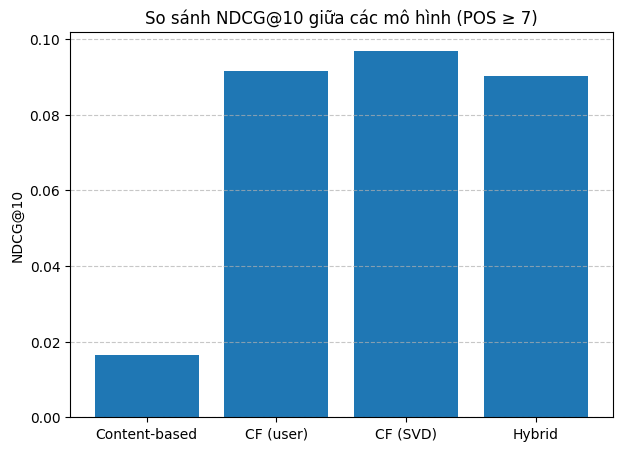

In [17]:
import matplotlib.pyplot as plt
import numpy as np

pos = 7
metric = "ndcg@10"

cb_mean   = cb_results_df [cb_results_df ['pos_thresh']==pos][metric].mean()
cf_mean   = ub_results_df [ub_results_df ['pos_thresh']==pos][metric].mean()      # user-based
svd_mean  = svd_results_df[svd_results_df['pos_thresh']==pos][metric].mean()     # SVD
hyb_mean  = hyb_eval_df   [hyb_eval_df   ['pos_thresh']==pos][metric].mean()     # hybrid

labels = ["Content-based", "CF (user)", "CF (SVD)", "Hybrid"]
values = [cb_mean, cf_mean, svd_mean, hyb_mean]

plt.figure(figsize=(7,5))
plt.bar(labels, values)
plt.ylabel("NDCG@10")
plt.title("So sánh NDCG@10 giữa các mô hình (POS ≥ 7)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [20]:
POS = 7
metrics = ["hit@10", "precision@10", "recall@10", "ndcg@10"]

def get_row(df, name):
    sub = df[df["pos_thresh"] == POS]
    row = {"Model": name}
    for m in metrics:
        if m in sub.columns:
            row[m] = sub[m].mean()
    return row

rows = [
    get_row(cb_results_df,  "Content-based"),
    get_row(ub_results_df,  "CF (user)"),
    get_row(svd_results_df, "CF (SVD)"),
    get_row(hyb_eval_df,    "Hybrid"),
]

compare_df = pd.DataFrame(rows)
print("=== So sánh các chỉ số (POS ≥ 7, K = 10) ===")
print(compare_df.round(4).to_string(index=False))



=== So sánh các chỉ số (POS ≥ 7, K = 10) ===
        Model  hit@10  precision@10  recall@10  ndcg@10
Content-based  0.0322        0.0036     0.0085   0.0165
    CF (user)  0.1667        0.0204     0.0498   0.0917
     CF (SVD)  0.1772        0.0215     0.0450   0.0970
       Hybrid  0.1643        0.0201     0.0494   0.0904


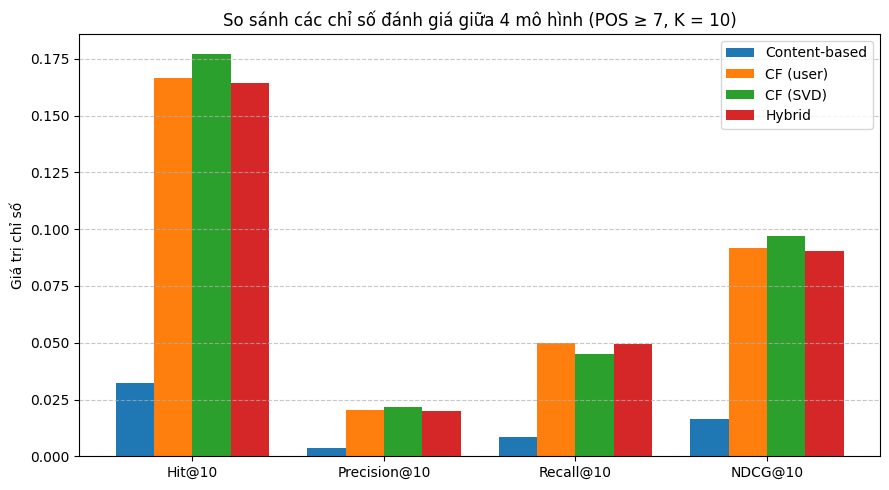

In [21]:
POS = 7
metrics = ["hit@10", "precision@10", "recall@10", "ndcg@10"]
metric_labels = ["Hit@10", "Precision@10", "Recall@10", "NDCG@10"]

def vals(df):
    sub = df[df["pos_thresh"] == POS]
    return [sub[m].mean() for m in metrics]

cb_vals   = vals(cb_results_df)
cf_vals   = vals(ub_results_df)
svd_vals  = vals(svd_results_df)
hyb_vals  = vals(hyb_eval_df)

x = np.arange(len(metrics))         # vị trí các nhóm metric
width = 0.2                         # độ rộng mỗi cột

plt.figure(figsize=(9,5))
plt.bar(x - 1.5*width, cb_vals,   width, label="Content-based")
plt.bar(x - 0.5*width, cf_vals,   width, label="CF (user)")
plt.bar(x + 0.5*width, svd_vals,  width, label="CF (SVD)")
plt.bar(x + 1.5*width, hyb_vals,  width, label="Hybrid")

plt.xticks(x, metric_labels)
plt.ylabel("Giá trị chỉ số")
plt.title("So sánh các chỉ số đánh giá giữa 4 mô hình (POS ≥ 7, K = 10)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

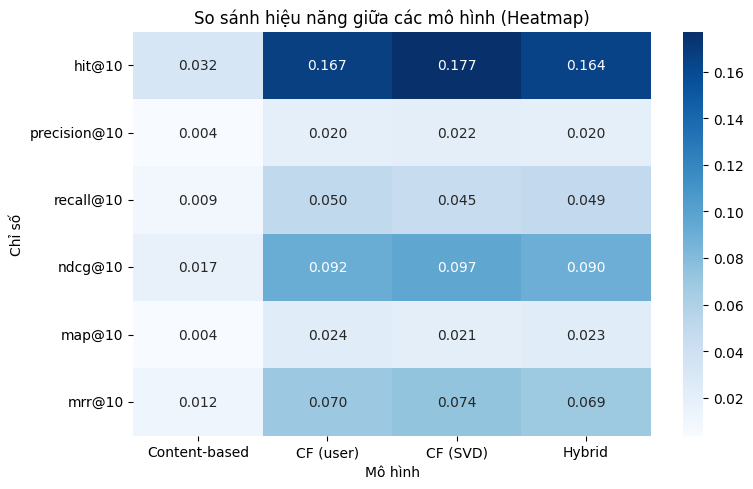

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

POS = 7
metrics = ["hit@10","precision@10","recall@10","ndcg@10","map@10","mrr@10"]

rows = {
    "Content-based": [cb_results_df[cb_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "CF (user)":     [ub_results_df[ub_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "CF (SVD)":      [svd_results_df[svd_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "Hybrid":        [hyb_eval_df[hyb_eval_df['pos_thresh']==POS][m].mean() for m in metrics],
}

df = pd.DataFrame(rows, index=metrics)

plt.figure(figsize=(8,5))
sns.heatmap(df, annot=True, cmap="Blues", fmt=".3f")
plt.title("So sánh hiệu năng giữa các mô hình (Heatmap)")
plt.ylabel("Chỉ số")
plt.xlabel("Mô hình")
plt.tight_layout()
plt.show()
